In [2]:
import sklearn
import skimage
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.decomposition import IncrementalPCA
from PIL import Image
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import block_reduce
from scipy.stats import gmean

import glob

In [3]:
def get_tile_x(image_number): #Gets the horizontal position of the tile (0 on the left)
    return np.mod(image_number,horizontal_number)

In [4]:
def get_tile_y(image_number): #Gets the vertical position of the tile (0 at the top)
    return np.floor_divide(image_number,horizontal_number)

In [5]:
def get_tile_point(image_number): #Gets the horizontal and vertical positions of the tile as a tuple of the form (hori, vert), 0,0 in top left
    return (np.mod(image_number,horizontal_number),np.floor_divide(image_number,horizontal_number))


In [6]:
def get_tile_number(tile_point): #Gets the number of a tile from its point in the grid
    return(tile_point[0]+horizontal_number*tile_point[1])


In [7]:
def check_brightness_position(image_number,point,x_size, y_size, bright): #Plots a square on the image so that it is possible to see exactly where is being searched
    image = ims_brightened[image_number]
    colors = [0, 0.8]
    color = bright #0 marks a dark square, 1 marks a bright square
    x = point[0]
    y = point[1]
    image[y+y_size, (x-x_size):(x+x_size)] = 0.8
    image[y-y_size, (x-x_size):(x+x_size)] = 0.8 
    image[(y-y_size):(y+y_size), x+x_size] = 0.8
    image[(y-y_size):(y+y_size), x-x_size] = 0.8
    print("Image number: ", image_number, " Comparison location:", point, " Size: ", x_size, " x ", y_size , " rectangle drawn")
    #return np.median(brightness_array)

In [8]:
def get_brightness(image_number,point,x_size, y_size): #Gets the mean brightness of a square extending size units out in each direction 
    image = ims_brightened[image_number] #This takes the point in the form x-y, this is a mistake but is also fine
    x = point[0]
    y = point[1]
    brightness_array = []
    for i in range((2*y_size)+1):
        for j in range((2*x_size)+1):
            brightness_array.append(image[y-y_size+i][x-x_size+j])
            #print(y-size+i, x-size+j, image[y-size+i][x-size+j])
    brightness_array = np.array(brightness_array)
    confidence = len(brightness_array[brightness_array>(40/256)])
    if confidence != 0:
        mean_of_brights = np.mean(brightness_array[brightness_array>(40/256)])
    else:
        mean_of_brights = -999
    print("Image number: ", image_number, " Comparison location:", point, " Size: ", x_size, " x ", y_size , " Brightness: ", mean_of_brights)
    
    return mean_of_brights, confidence
    #return np.median(brightness_array)

In [115]:
ims_brightened[0]

array([[0.04687572, 0.0390631 , 0.04296941, ..., 0.03125048, 0.03515679,
        0.03515679],
       [0.03515679, 0.03125048, 0.04687572, ..., 0.8       , 0.8       ,
        0.04687572],
       [0.02734417, 0.0390631 , 0.02734417, ..., 0.03515679, 0.8       ,
        0.05468833],
       ...,
       [0.03125048, 0.04296941, 0.03515679, ..., 0.04296941, 0.8       ,
        0.8       ],
       [0.04687572, 0.0390631 , 0.05468833, ..., 0.03125048, 0.8       ,
        0.8       ],
       [0.03125048, 0.03515679, 0.05468833, ..., 0.8       , 0.8       ,
        0.0390631 ]], dtype=float32)

In [86]:
ims_brightened[1]*256

array([[ 12.43602  ,  13.392637 ,  13.392637 , ..., 108.998276 ,
        113.80005  , 121.21382  ],
       [ 15.305871 ,  10.522786 ,  11.4794035, ..., 114.846344 ,
        112.42117  , 110.90404  ],
       [ 13.392637 ,   9.56617  ,  12.43602  , ..., 116.35227  ,
        115.24245  , 117.86193  ],
       ...,
       [  9.56617  ,   8.609552 ,  13.392637 , ..., 113.747734 ,
        111.77097  , 116.29248  ],
       [ 15.305871 ,  12.43602  ,  12.43602  , ..., 119.09507  ,
        115.95991  , 113.36658  ],
       [  9.56617  ,  10.522786 ,  12.43602  , ..., 121.8304   ,
        112.97795  , 116.62879  ]], dtype=float32)

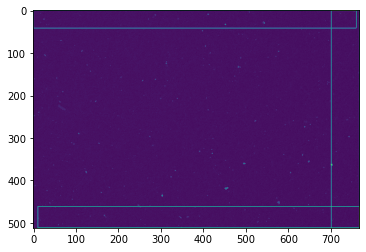

In [167]:
plt.imshow(ims_brightened[11])

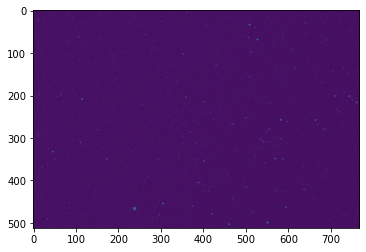

In [183]:
plt.imshow(ims[0])

In [121]:
get_brightness_factor(get_tile_point(3), get_tile_point(4))

Image number:  3  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45476785
Image number:  4  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.45784146


(1.0067586, 33847.0)

In [14]:
#This space exists to avoid scrolling

In [9]:
def check_get_brightness_position(image_1_point, image_2_point): #Replica of the point selection logic but instead marks the points
    
    tile_1_x = image_1_point[0] #Legacy from the version of this function which used image numbers
    tile_1_y = image_1_point[1]
    tile_2_x = image_2_point[0]
    tile_2_y = image_2_point[1]
    image_1_number = get_tile_number(image_1_point)
    image_2_number = get_tile_number(image_2_point)
    #tile_1_x = get_tile_x(image_1_number) 
    #tile_1_y = get_tile_y(image_1_number)
    #tile_2_x = get_tile_x(image_2_number)
    #tile_2_y = get_tile_y(image_2_number)
    
    
    #Locations of the centres of the edges of any given tile
    right_edge = np.array((ims[0].shape[1]-1,ims[0].shape[0]/2))
    left_edge = np.array((0,ims[0].shape[0]/2))
    bottom_edge = np.array((ims[0].shape[1]/2,ims[0].shape[0]-1))
    top_edge = np.array((ims[0].shape[1]/2,0))
    
    #I apologise but this is going to be sign hell
    
    
    #Unless something very strange happens the limiting dimension of left-right comparison area sizes will be the width of the overlap area, and top-bottom sizes will be limited by the height
    overlap_area_width = horizontal_overlap + np.sign(tile_1_x-tile_2_x)*(horizontal_columnwise_tuning[tile_1_x] - horizontal_columnwise_tuning[tile_2_x])
    overlap_area_height = vertical_overlap + np.sign(tile_1_y-tile_2_y)*(vertical_rowwise_tuning[tile_1_y] - vertical_rowwise_tuning[tile_2_y])
    #The above only apply when the overlap is primarily left-right and top-bottom, respectively
    
    
    #Pre computing tuning values to keep them out of the if nest for clarity
    tuning_x = horizontal_columnwise_tuning[tile_1_x] - horizontal_columnwise_tuning[tile_2_x] + horizontal_rowwise_tuning[tile_1_y] - horizontal_rowwise_tuning[tile_2_y]
    tuning_y = vertical_columnwise_tuning[tile_1_x] - vertical_columnwise_tuning[tile_2_x] + vertical_rowwise_tuning[tile_1_y] - vertical_rowwise_tuning[tile_2_y]
    
    #tuning x and tuning y are the "leftness" and "upness" of the primary tile relative to the secondary
    #They should be ADDED to the primary edge-secondary edge vector because greater primary leftness means the vector needs to be more rightward
    #similarly greater primary upness means the primary edge-secondary edge vector needs a greater downward component
    #This vector flip is inherited from the tile positioning logic
    
    #When the tiles are placed directly next to eachother with edges aligned, this is the vector from primary edge point to secondary edge point
    nudge = np.array([(tile_2_x-tile_1_x), (tile_2_y-tile_1_y)])
    
    #Goal is to find the vector from the relevant edge of the primary tile to the relevant edge of the secondary tile
    #Find the midpoint of that vector
    #Find that point in both image coordinate systems
    
    if abs(tile_1_x-tile_2_x) == 1 and tile_1_y-tile_2_y == 0: #if tiles are left-right adjacent
        
        relative_y = tuning_y #the y component of the primary edge-secondary edge vector in stitched space
        relative_x = (np.sign(tile_1_x-tile_2_x)*overlap_area_width) + nudge[0] #the x component
        edge_edge_vector = np.array((relative_x, relative_y)) #Vector from the relevant edge of the primary tile to the relevant edge of the secondary tile in stitched space
        x_size_limit = int(np.floor((overlap_area_width-1)/2)) #if odd this needs to just be the floor of the half, but if even it needs to be 1 less than the floor of the half, this achieves that 
        y_size_limit = int(np.floor(((ims[0].shape[0] - abs(tuning_y))-1)/2)) 
        if tile_1_x > tile_2_x: #tile 1 is on the right of tile 2
            
            tile_1_point = left_edge + np.floor(edge_edge_vector/2) #in a case where this vector is odd, these must be rounded to avoid looking for fractional pixels,
            tile_2_point = right_edge - np.ceil(edge_edge_vector/2) #without floor and ceil the target pixels would be next to eachother instead of on top
        
        if tile_1_x < tile_2_x: #tile 1 is on the left of tile 2
            
            tile_1_point = right_edge + np.floor(edge_edge_vector/2)
            tile_2_point = left_edge - np.ceil(edge_edge_vector/2)
            
    elif abs(tile_1_y-tile_2_y) == 1 and tile_1_x-tile_2_x == 0: #if tiles are top-bottom adjacent
        
        relative_x = tuning_x #the x component of the primary edge-secondary edge vector in stitched space
        relative_y = (np.sign(tile_1_y-tile_2_y)*overlap_area_height) + nudge[1] #the y component
        edge_edge_vector = np.array((relative_x, relative_y)) #Vector from the relevant edge of the primary tile to the relevant edge of the secondary tile in stitched space
        y_size_limit = int(np.floor((overlap_area_height-1)/2))
        x_size_limit = int(np.floor(((ims[0].shape[1] - abs(tuning_x))-1)/2)) 
        if tile_1_y > tile_2_y: #tile 1 is below tile 2
            
            tile_1_point = top_edge + np.floor(edge_edge_vector/2) #in a case where this vector is odd, these must be rounded to avoid looking for fractional pixels,
            tile_2_point = bottom_edge - np.ceil(edge_edge_vector/2) #without floor and ceil the target pixels would be next to eachother instead of on top
        
        if tile_1_y < tile_2_y: #tile 1 is above tile 2
            
            tile_1_point = bottom_edge + np.floor(edge_edge_vector/2)
            tile_2_point = top_edge - np.ceil(edge_edge_vector/2)
            
    else:
        print("WARNING: images ", image_1_number, " and ", image_2_number, " sent to get_brightness_factor do not share an edge")
        return 1
    
    #look_here = np.array((1,1)) - abs(nudge)
    #for i in range(5):
    #    tile_1_point_final = tile_1_point + (size_limit*2*look_here*(3-i))
    #    tile_2_point_final = tile_2_point + (size_limit*2*look_here*(3-i))
    #    tile_1_point_final = tuple(map(int, tile_1_point_final)) #Convert the tuples of floats made above into tuples of integers
    #    tile_2_point_final = tuple(map(int, tile_2_point_final))
    #    check_brightness_position(image_1_number, tile_1_point_final, size_limit, 1)
    #    check_brightness_position(image_2_number, tile_2_point_final, size_limit, 0)
    
    
    tile_1_point = tuple(map(int, tile_1_point)) #Convert the tuples of floats made above into tuples of integers
    tile_2_point = tuple(map(int, tile_2_point))
    check_brightness_position(image_1_number, tile_1_point, x_size_limit, y_size_limit, 1)
    check_brightness_position(image_2_number, tile_2_point, x_size_limit, y_size_limit, 0)
    

In [10]:
def get_brightness_factor(image_1_point, image_2_point): #Gets the factor by which image 2's brightnesses must be scaled to match image 1
    
    tile_1_x = image_1_point[0] #Legacy from the version of this function which used image numbers
    tile_1_y = image_1_point[1]
    tile_2_x = image_2_point[0]
    tile_2_y = image_2_point[1]
    image_1_number = get_tile_number(image_1_point)
    image_2_number = get_tile_number(image_2_point)
    #tile_1_x = get_tile_x(image_1_number) 
    #tile_1_y = get_tile_y(image_1_number)
    #tile_2_x = get_tile_x(image_2_number)
    #tile_2_y = get_tile_y(image_2_number)
    
    
    #Locations of the centres of the edges of any given tile
    right_edge = np.array((ims[0].shape[1]-1,ims[0].shape[0]/2))
    left_edge = np.array((0,ims[0].shape[0]/2))
    bottom_edge = np.array((ims[0].shape[1]/2,ims[0].shape[0]-1))
    top_edge = np.array((ims[0].shape[1]/2,0))
    
    #I apologise but this is going to be sign hell
    
    
    #Unless something very strange happens the limiting dimension of left-right comparison area sizes will be the width of the overlap area, and top-bottom sizes will be limited by the height
    overlap_area_width = horizontal_overlap + np.sign(tile_1_x-tile_2_x)*(horizontal_columnwise_tuning[tile_1_x] - horizontal_columnwise_tuning[tile_2_x])
    overlap_area_height = vertical_overlap + np.sign(tile_1_y-tile_2_y)*(vertical_rowwise_tuning[tile_1_y] - vertical_rowwise_tuning[tile_2_y])
    #The above only apply when the overlap is primarily left-right and top-bottom, respectively
    
    
    #Pre computing tuning values to keep them out of the if nest for clarity
    tuning_x = horizontal_columnwise_tuning[tile_1_x] - horizontal_columnwise_tuning[tile_2_x] + horizontal_rowwise_tuning[tile_1_y] - horizontal_rowwise_tuning[tile_2_y]
    tuning_y = vertical_columnwise_tuning[tile_1_x] - vertical_columnwise_tuning[tile_2_x] + vertical_rowwise_tuning[tile_1_y] - vertical_rowwise_tuning[tile_2_y]
    
    #tuning x and tuning y are the "leftness" and "upness" of the primary tile relative to the secondary
    #They should be ADDED to the primary edge-secondary edge vector because greater primary leftness means the vector needs to be more rightward
    #similarly greater primary upness means the primary edge-secondary edge vector needs a greater downward component
    #This vector flip is inherited from the tile positioning logic
    
    #When the tiles are placed directly next to eachother with edges aligned, this is the vector from primary edge point to secondary edge point
    nudge = np.array([(tile_2_x-tile_1_x), (tile_2_y-tile_1_y)])
    
    #Goal is to find the vector from the relevant edge of the primary tile to the relevant edge of the secondary tile
    #Find the midpoint of that vector
    #Find that point in both image coordinate systems
    
    if abs(tile_1_x-tile_2_x) == 1 and tile_1_y-tile_2_y == 0: #if tiles are left-right adjacent
        
        relative_y = tuning_y #the y component of the primary edge-secondary edge vector in stitched space
        relative_x = (np.sign(tile_1_x-tile_2_x)*overlap_area_width) + nudge[0] #the x component
        edge_edge_vector = np.array((relative_x, relative_y)) #Vector from the relevant edge of the primary tile to the relevant edge of the secondary tile in stitched space
        x_size_limit = int(np.floor((overlap_area_width-1)/2)) #if odd this needs to just be the floor of the half, but if even it needs to be 1 less than the floor of the half, this achieves that 
        y_size_limit = int(np.floor(((ims[0].shape[0] - abs(tuning_y))-1)/2)) 
        if tile_1_x > tile_2_x: #tile 1 is on the right of tile 2
            
            tile_1_point = left_edge + np.floor(edge_edge_vector/2) #in a case where this vector is odd, these must be rounded to avoid looking for fractional pixels,
            tile_2_point = right_edge - np.ceil(edge_edge_vector/2) #without floor and ceil the target pixels would be next to eachother instead of on top
        
        if tile_1_x < tile_2_x: #tile 1 is on the left of tile 2
            
            tile_1_point = right_edge + np.floor(edge_edge_vector/2)
            tile_2_point = left_edge - np.ceil(edge_edge_vector/2)
            
    elif abs(tile_1_y-tile_2_y) == 1 and tile_1_x-tile_2_x == 0: #if tiles are top-bottom adjacent
        
        relative_x = tuning_x #the x component of the primary edge-secondary edge vector in stitched space
        relative_y = (np.sign(tile_1_y-tile_2_y)*overlap_area_height) + nudge[1] #the y component
        edge_edge_vector = np.array((relative_x, relative_y)) #Vector from the relevant edge of the primary tile to the relevant edge of the secondary tile in stitched space
        y_size_limit = int(np.floor((overlap_area_height-1)/2))
        x_size_limit = int(np.floor(((ims[0].shape[1] - abs(tuning_x))-1)/2)) 
        if tile_1_y > tile_2_y: #tile 1 is below tile 2
            
            tile_1_point = top_edge + np.floor(edge_edge_vector/2) #in a case where this vector is odd, these must be rounded to avoid looking for fractional pixels,
            tile_2_point = bottom_edge - np.ceil(edge_edge_vector/2) #without floor and ceil the target pixels would be next to eachother instead of on top
        
        if tile_1_y < tile_2_y: #tile 1 is above tile 2
            
            tile_1_point = bottom_edge + np.floor(edge_edge_vector/2)
            tile_2_point = top_edge - np.ceil(edge_edge_vector/2)
            
    else:
        print("WARNING: images ", image_1_number, " and ", image_2_number, " sent to get_brightness_factor do not share an edge")
        return 1
    
    #look_here = np.array((1,1)) - abs(nudge)
    #for i in range(5):
    #    tile_1_point_final = tile_1_point + (size_limit*2*look_here*(3-i))
    #    tile_2_point_final = tile_2_point + (size_limit*2*look_here*(3-i))
    #    tile_1_point_final = tuple(map(int, tile_1_point_final)) #Convert the tuples of floats made above into tuples of integers
    #    tile_2_point_final = tuple(map(int, tile_2_point_final))
    #    check_brightness_position(image_1_number, tile_1_point_final, size_limit, 1)
    #    check_brightness_position(image_2_number, tile_2_point_final, size_limit, 0)
    
    
    tile_1_point = tuple(map(int, tile_1_point)) #Convert the tuples of floats made above into tuples of integers
    tile_2_point = tuple(map(int, tile_2_point))
    tile_1_brightness, tile_1_confidence = get_brightness(image_1_number, tile_1_point, x_size_limit, y_size_limit)
    tile_2_brightness, tile_2_confidence = get_brightness(image_2_number, tile_2_point, x_size_limit, y_size_limit)
    
    
    
    return tile_2_brightness/tile_1_brightness, (tile_1_confidence+tile_2_confidence)/2
    
    
    
            

In [12]:
#ims_brightened[14].shape

In [13]:
#get_tile_point(13)

In [14]:
#get_brightness_factor(get_tile_point(188), get_tile_point(199))

In [11]:
def do_tile(image_point, done_tracker): #Calibrates the brightness of a given tile
    working_ratios = []
    working_confidences = []
    adjustment_list = np.array([np.array([0, -1]), np.array([1, 0]), np.array([0, 1]), np.array([-1, 0])]) 
    
    for i in range(4):
        neighbour_in_question_point = image_point+adjustment_list[i] #consider a neighbour
        if neighbour_in_question_point[0] < horizontal_number and neighbour_in_question_point[0] >=0 and neighbour_in_question_point[1] <vertical_number and neighbour_in_question_point[1] >= 0:  
            if done_tracker[neighbour_in_question_point[0], neighbour_in_question_point[1]] == 1: #if it has been done
                ratio, confidence = get_brightness_factor(neighbour_in_question_point, image_point) #list the factor between the tile and neighbour
                working_ratios.append(ratio)
                working_confidences.append(confidence)
                #check_get_brightness_position(neighbour_in_question_point, image_point) #debugging tool which marks where the brightness factor finder is looking
    working_ratios = np.array(working_ratios)
    working_confidences = np.array(working_confidences)
    overall_ratio = np.sum(working_ratios*working_confidences)/np.sum(working_confidences)
    
    #if len(working_ratios)>=1: 
    #    overall_ratio = np.median(working_ratios) 
    #   print(overall_ratio)
    #else:
    #    overall_ratio = 1
    #    print("BADBADBADBAD")
        
    #take median, this is simple but might work fairly nicely, the nuclear option would be to least squares fit, which in the case of 1 or 2 neighbours (most common) is identical, and this may help avoid outliers in 3 or 4-neighbour cases
    ims_brightened[get_tile_number(image_point)] = ims[get_tile_number(image_point)]*overall_ratio
    
    done_tracker[image_point[0]][ image_point[1]] += 1 #Mark tile as done
    brightness_tracker[image_point[0]][ image_point[1]] += overall_ratio #debugging tool
    
    
    return done_tracker

In [12]:
def find_done_neighbour_numbers(done_tracker):
    #Yes I'm iterating over the whole thing instead of being selective what of it
    neighbour_tracker = np.zeros((horizontal_number, vertical_number))
    for i in range(horizontal_number):
        for j in range(vertical_number):
            if done_tracker[i][j] == 1:
                #print(i," ",j)
                neighbours = np.array([np.array([i, j-1]), np.array([i+1, j]), np.array([i, j+1]), np.array([i-1, j])]) 
                for k in range(4):
                    if neighbours[k][0] < horizontal_number and neighbours[k][0] >=0 and neighbours[k][1] <vertical_number and neighbours[k][1] >= 0:
                        #print(neighbours[k])
                        neighbour_tracker[neighbours[k][0], neighbours[k][1]] +=1
    #clean up, since done tiles might otherwise be the tiles with the most neighbours
    for i in range(horizontal_number):
        for j in range(vertical_number):
            if done_tracker[i][j] != 0:
                neighbour_tracker[i][j] = 0
    return neighbour_tracker
            
            
            

In [74]:
def get_origins(inboard_layout):
    origin_numbers = []
    origin_layout = layout.copy()
    for i in range(origin_layout.shape[0]-2):
        for j in range(origin_layout.shape[1]-2):
            origin_layout[i+1, j+1] = np.sum(inboard_layout[i:i+3, j:j+3])
    valid_origins = origin_layout==9
    origin_points = np.argwhere((valid_origins == 1))
    for i in origin_points:
        origin_numbers.append(get_tile_number(i))
    
    return origin_numbers

In [42]:
def propagate_brightness(origins):
    number_of_runs_to_average = 25
    brightness_tracker_set = np.zeros((number_of_runs_to_average*len(origins), horizontal_number, vertical_number))
    for j in range(len(origins)):
        start_tile_number = origins[j]
        for i in range(number_of_runs_to_average):

            global ims_brightened
            ims_brightened = ims.copy()
            done_tracker = np.zeros((horizontal_number, vertical_number))
            done_tracker[get_tile_point(start_tile_number)] = 1
            global brightness_tracker
            brightness_tracker = np.zeros((horizontal_number, vertical_number))
            brightness_tracker[get_tile_point(start_tile_number)] = 1

            #for i in range(10):
            while np.min(done_tracker) == 0:
                neighbour_array = find_done_neighbour_numbers(done_tracker)
                #print(neighbour_array)
                #tile_with_most_neighbours = np.unravel_index(neighbour_array.argmax(), neighbour_array.shape)
                #print(tile_with_most_neighbours)
                #find list of indices of tiles with highest number of neighbours, instead of just the first instance which produces a top-left bias
                inboard_neighbours = neighbour_array*inboard_layout
                edge_neighbours = neighbour_array*edge_layout
                black_neighbours = neighbour_array*black_layout
                
                if np.max(inboard_neighbours) >0:
                    options = np.argwhere((inboard_neighbours == np.max(inboard_neighbours)))
                elif np.max(edge_neighbours) >0:
                    options = np.argwhere((edge_neighbours == np.max(edge_neighbours)))
                else:
                    options = np.argwhere((black_neighbours == np.max(black_neighbours)))
                    
                
                #options = np.argwhere((neighbour_array == np.max(neighbour_array)))
                #print(options)
                selected = np.array(options[np.random.randint(0, options.shape[0])])
                #print(selected)
                done_tracker = do_tile(selected, done_tracker)
                #print(done_tracker)
            print(brightness_tracker)
            token_number = i+(number_of_runs_to_average*j)
            brightness_tracker_set[token_number] =  brightness_tracker

    
    #global overall_brightness_tracker
    overall_brightness_tracker = np.transpose(gmean(brightness_tracker_set, 0))
    print(overall_brightness_tracker)
    return overall_brightness_tracker
    
    #    primary_x = get_tile_x(start_tile)
    #    primary_y = get_tile_y(start_tile)
    #    side_codes = np.array(["Top", "Right", "Bottom", "Left"])
    #    #top-right-bottom-left
    #    edge_buds = np.array([np.array([primary_x, primary_y-1]), np.array([primary_x+1, primary_y]), np.array([primary_x, primary_y+1]), np.array([primary_x-1, primary_y])]) 
    #    #progress
    #    print(edge_buds)
    #    for i in range(4): #build the initial edges
    #        build_new_edge(edge_buds[i], side_codes[i])
    #        
    #    build_corners(edge_buds) #build the corners




        #print(done_tracker)

In [47]:
ims_reshaped = ims.copy()   
ims_reshaped = np.reshape(ims_reshaped, (vertical_number, horizontal_number, ims[0].shape[0], ims[0].shape[1]))
ims_brightened_overall = np.zeros((vertical_number, horizontal_number, ims[0].shape[0], ims[0].shape[1]))
for i in range(vertical_number):
    for j in range(horizontal_number):
        ims_brightened_overall[i,j] = ims_reshaped[i,j]*overall_brightness_tracker[i,j]

In [159]:
#overall_brightness_tracker = [[1.11467289, 0.98636859, 1.07209015],
#[1.00737486, 1.00521794, 1.07325913],
#[1.01013662, 1.0071234,  1.00399005],
#[1.00473512, 0.99940295, 1.00713159],
#[0.99118123, 1.01185588, 0.99697581],
#[1.0004881,  0.99553591, 1.00369655],
#[0.99787988, 0.,         1.00049363],
#[0.99926029, 1.00334255, 1.00199146],
#[1.00987232, 1.01606467, 0.99925823],
#[1.1434904,  0.99704298, 1.00797722],
#[1.07872491, 1.01999023, 1.0355848 ]]
#overall_brightness_tracker = np.transpose(np.array(overall_brightness_tracker))

In [46]:
acceptable_origins = [15,16]
overall_brightness_tracker = propagate_brightness(acceptable_origins)

Image number:  15  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45853034
Image number:  16  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46154115
Image number:  15  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.4573941
Image number:  4  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4560339
Image number:  16  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.4663757
Image number:  5  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.46244997
Image number:  4  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46135923
Image number:  5  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46564662
Image number:  16  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.4713776
Image number:  27  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.46923926
Image number:  15  Comparison location: (389, 486)  Size:  378 

Image number:  22  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.227217
Image number:  23  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.26885068
Image number:  22  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.28443605
Image number:  20  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.22775967
Image number:  21  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.23695922
Image number:  21  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.2310406
Image number:  32  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.23587641
Image number:  31  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4558478
Image number:  32  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.45883518
Image number:  21  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.28746644
Image number:  10  Comparison location: (388, 490)  Size:  3

Image number:  12  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46236995
Image number:  1  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4657746
Image number:  20  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.42927557
Image number:  9  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4307918
Image number:  8  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.43793496
Image number:  9  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.43196282
Image number:  12  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.4457777
Image number:  23  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.45253143
Image number:  24  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.44787163
Image number:  23  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45277524
Image number:  20  Comparison location: (733, 256)  Size:  33 

Image number:  14  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.45887595
Image number:  13  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45712602
Image number:  13  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.45391545
Image number:  24  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.45438924
Image number:  25  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.45797393
Image number:  24  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.457347
Image number:  19  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.45991567
Image number:  8  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.46013847
Image number:  7  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45767406
Image number:  8  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4560954
Image number:  31  Comparison location: (378, 25)  Size:  378

Image number:  13  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.45373312
Image number:  24  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.45438924
Image number:  25  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4623328
Image number:  24  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.457347
Image number:  3  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.44947925
Image number:  2  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.44596
Image number:  13  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46634206
Image number:  2  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4647232
Image number:  17  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46376103
Image number:  18  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46393067
Image number:  18  Comparison location: (380, 21)  Size:  379  x 

Image number:  15  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.4573941
Image number:  4  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4560339
Image number:  16  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.4663757
Image number:  5  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.46244997
Image number:  4  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46135923
Image number:  5  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46564662
Image number:  17  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.45919195
Image number:  6  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.461174
Image number:  5  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46638715
Image number:  6  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4685102
Image number:  18  Comparison location: (380, 21)  Size:  379  x  21

Image number:  5  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46564662
Image number:  5  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.46674746
Image number:  16  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46333337
Image number:  15  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45853034
Image number:  16  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46154115
Image number:  16  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46533114
Image number:  17  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4680885
Image number:  17  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46459156
Image number:  6  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.461174
Image number:  5  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4704183
Image number:  6  Comparison location: (33, 256)  Size:  33  x 

Image number:  22  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.28443605
Image number:  20  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.2335246
Image number:  21  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.23695922
Image number:  21  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.23753531
Image number:  32  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.23587641
Image number:  31  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4588976
Image number:  32  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.45883518
Image number:  21  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.2954638
Image number:  10  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.30438772
Image number:  9  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.2144221
Image number:  10  Comparison location: (33, 256)  Size:  3

Image number:  20  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.4293875
Image number:  9  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4307918
Image number:  8  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4376584
Image number:  9  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.43196282
Image number:  12  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.449558
Image number:  23  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.45253143
Image number:  24  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.45428512
Image number:  23  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45277524
Image number:  20  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.23476079
Image number:  21  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.23695922
Image number:  21  Comparison location: (380, 21)  Size:  379  

Image number:  31  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.4675333
Image number:  20  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.47070155
Image number:  19  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46918538
Image number:  20  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46769878
Image number:  19  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.45936972
Image number:  8  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.46013847
Image number:  7  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45790932
Image number:  8  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4560954
Image number:  2  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46314478
Image number:  1  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4661647
Image number:  1  Comparison location: (388, 490)  Size:  379  

Image number:  25  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45890918
Image number:  14  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.45646653
Image number:  13  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45712602
Image number:  13  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.45373312
Image number:  24  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.45438924
Image number:  25  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46195853
Image number:  24  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.457347
Image number:  3  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4489116
Image number:  2  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.44596
Image number:  13  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46634206
Image number:  2  Comparison location: (388, 490)  Size:  379  

Image number:  29  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.4631202
Image number:  28  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.47023797
Image number:  29  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.47086033
Image number:  15  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.4573941
Image number:  4  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4560339
Image number:  16  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.4635128
Image number:  5  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.46244997
Image number:  4  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46135923
Image number:  5  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46564662
Image number:  17  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46149457
Image number:  6  Comparison location: (388, 490)  Size:  379  x

Image number:  15  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.4573941
Image number:  4  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4560339
Image number:  4  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4565244
Image number:  3  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45476785
Image number:  14  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.4647507
Image number:  3  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4686892
Image number:  3  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.44947925
Image number:  2  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.44596
Image number:  13  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46634206
Image number:  2  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4647232
Image number:  15  Comparison location: (733, 256)  Size:  33  x  255  

Image number:  15  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.4599259
Image number:  26  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.4608024
Image number:  26  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.44215462
Image number:  27  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.44351417
Image number:  27  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.4706821
Image number:  16  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.46830267
Image number:  15  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45853034
Image number:  16  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46154115
Image number:  15  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4542442
Image number:  14  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4503688
Image number:  14  Comparison location: (389, 486)  Size:  3

Image number:  31  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45514187
Image number:  32  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.45883518
Image number:  12  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.3473359
Image number:  11  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.3665276
Image number:  1  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.2385059
Image number:  0  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.2348929
Image number:  11  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.30521908
Image number:  0  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.29502288
Image number:  11  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.22939757
Image number:  22  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.227217
Image number:  23  Comparison location: (33, 256)  Size:  33  x 

Image number:  12  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.468345
Image number:  1  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4657746
Image number:  20  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.4296547
Image number:  9  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4307918
Image number:  8  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.43812877
Image number:  9  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.43196282
Image number:  12  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.45118988
Image number:  23  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.45253143
Image number:  24  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.45623028
Image number:  23  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45277524
Image number:  23  Comparison location: (33, 256)  Size:  33  x 

Image number:  30  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.46638528
Image number:  19  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.4646373
Image number:  18  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46647483
Image number:  19  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46681508
Image number:  30  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.47021055
Image number:  31  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46696705
Image number:  31  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.46758375
Image number:  20  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.47070155
Image number:  19  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4692425
Image number:  20  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46769878
Image number:  19  Comparison location: (380, 21)  Size: 

Image number:  2  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4623038
Image number:  13  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46566924
Image number:  14  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.45933896
Image number:  13  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45712602
Image number:  13  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.4535724
Image number:  24  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.45438924
Image number:  25  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4571162
Image number:  24  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.457347
Image number:  6  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4528828
Image number:  7  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4546257
Image number:  7  Comparison location: (388, 490)  Size:  379  x 

Image number:  13  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.45373312
Image number:  24  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.45438924
Image number:  25  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46155393
Image number:  24  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.457347
Image number:  15  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45853034
Image number:  16  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46154115
Image number:  16  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.4713776
Image number:  27  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.46923926
Image number:  26  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.44215462
Image number:  27  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.44351417
Image number:  16  Comparison location: (380, 21)  Size:  

Image number:  26  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.4608024
Image number:  27  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4422926
Image number:  26  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4413136
Image number:  26  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46110836
Image number:  25  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45890918
Image number:  15  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4542442
Image number:  14  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4503688
Image number:  25  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.44568446
Image number:  14  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.44623896
Image number:  16  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46845815
Image number:  17  Comparison location: (33, 256)  Size:  33

Image number:  11  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.22886682
Image number:  22  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.227217
Image number:  23  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.26811
Image number:  22  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.28443605
[[0.96668664 1.04718316 1.01765999]
 [0.99593297 1.00115681 0.99580283]
 [1.00160277 0.99618649 1.0028132 ]
 [1.00362711 0.99670187 0.99523067]
 [1.00015708 1.         1.00002931]
 [0.99912837 1.00656617 0.99546361]
 [1.0027102  0.99921095 1.00701842]
 [0.99606317 1.0067302  0.99627033]
 [1.00162873 0.99629527 1.00576426]
 [0.99107239 1.0038915  0.99052048]
 [1.04757992 1.01528191 1.00868726]]
Image number:  15  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45853034
Image number:  16  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46154115
Image number:  15  Comparison location: (

Image number:  24  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4576774
Image number:  23  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45277524
Image number:  12  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.35036606
Image number:  11  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.3665276
Image number:  11  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.2286361
Image number:  22  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.227217
Image number:  23  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.2677738
Image number:  22  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.28443605
Image number:  1  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.24083579
Image number:  0  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.2348929
Image number:  11  Comparison location: (380, 21)  Size:  379  x

Image number:  31  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.46914372
Image number:  20  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.47070155
Image number:  19  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.47105902
Image number:  20  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46769878
Image number:  2  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4660457
Image number:  1  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4661647
Image number:  1  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.46589354
Image number:  12  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46743703
Image number:  13  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.471815
Image number:  12  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4706743
Image number:  20  Comparison location: (380, 21)  Size:  379  

Image number:  30  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.46724993
Image number:  19  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.4646373
Image number:  18  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46745238
Image number:  19  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46681508
Image number:  3  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.44853342
Image number:  2  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.44596
Image number:  2  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.46214262
Image number:  13  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46566924
Image number:  14  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.45933896
Image number:  13  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45712602
Image number:  13  Comparison location: (389, 486)  Size:  378

Image number:  28  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.47156098
Image number:  29  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.47086033
Image number:  26  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46110836
Image number:  25  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45890918
Image number:  15  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4542442
Image number:  14  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4503688
Image number:  25  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.44568446
Image number:  14  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.44623896
Image number:  4  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4565244
Image number:  3  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45476785
Image number:  14  Comparison location: (380, 21)  Size:  37

Image number:  25  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45890918
Image number:  15  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4542442
Image number:  14  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4503688
Image number:  25  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.44484976
Image number:  14  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.44623896
Image number:  4  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4565244
Image number:  3  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45476785
Image number:  14  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.4676753
Image number:  3  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4686892
Image number:  3  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.448377
Image number:  2  Comparison location: (733, 256)  Size:  33  x  2

Image number:  15  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4542442
Image number:  14  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4503688
Image number:  14  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.44253692
Image number:  25  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.44772896
Image number:  15  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.4599259
Image number:  26  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.4608024
Image number:  25  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46429336
Image number:  26  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4610948
Image number:  15  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.4573941
Image number:  4  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4560339
Image number:  4  Comparison location: (33, 256)  Size:  33  x 

Image number:  20  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.23463833
Image number:  21  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.23695922
Image number:  21  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.23222923
Image number:  32  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.23587641
Image number:  31  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4571489
Image number:  32  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.45883518
Image number:  1  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.23811385
Image number:  0  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.2348929
Image number:  0  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.29725456
Image number:  11  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.3015793
Image number:  12  Comparison location: (33, 256)  Size:  33 

Image number:  2  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46634752
Image number:  1  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4661647
Image number:  1  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.46562532
Image number:  12  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46743703
Image number:  13  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.47063372
Image number:  12  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4706743
Image number:  12  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.45095885
Image number:  23  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.45253143
Image number:  24  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4552713
Image number:  23  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45277524
Image number:  20  Comparison location: (380, 21)  Size:  379

Image number:  3  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.44947925
Image number:  2  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.44596
Image number:  13  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46634206
Image number:  2  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4647232
Image number:  30  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46713755
Image number:  31  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46696705
Image number:  19  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.4627144
Image number:  8  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.46013847
Image number:  7  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.459982
Image number:  8  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4560954
Image number:  31  Comparison location: (378, 25)  Size:  378  x  25 

Image number:  7  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4601517
Image number:  6  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45388705
Image number:  7  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4546257
Image number:  18  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.46281675
Image number:  29  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.4631202
Image number:  28  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46667618
Image number:  29  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.47086033
Image number:  18  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46556658
Image number:  19  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46681508
Image number:  19  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.46588337
Image number:  30  Comparison location: (378, 25)  Size:  37

Image number:  25  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.44772896
Image number:  15  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.457013
Image number:  26  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.4608024
Image number:  25  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4614375
Image number:  26  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4610948
Image number:  16  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.46830267
Image number:  27  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.46923926
Image number:  26  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.44308347
Image number:  27  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.44351417
Image number:  13  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.451027
Image number:  24  Comparison location: (378, 25)  Size:  378 

Image number:  28  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.46506974
Image number:  16  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.46830267
Image number:  27  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.46923926
Image number:  28  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4651541
Image number:  27  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4633369
Image number:  16  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46154115
Image number:  15  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45853034
Image number:  15  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.457013
Image number:  26  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.4608024
Image number:  27  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.44396582
Image number:  26  Comparison location: (733, 256)  Size:  33

Image number:  10  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.30438772
Image number:  9  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.21153525
Image number:  10  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.22439578
Image number:  21  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.2380047
Image number:  32  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.23587641
Image number:  31  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45987782
Image number:  32  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.45883518
[[0.99197672 0.98024901 1.06036246]
 [1.00129282 0.99981168 0.99630115]
 [0.99651277 0.99886845 1.00221475]
 [0.99718561 1.00049855 0.99347901]
 [0.99822605 0.99347663 1.00179259]
 [1.00011106 1.         0.99922958]
 [0.99279577 1.00577188 0.99650896]
 [1.00666388 0.99492883 1.00896585]
 [0.99094904 1.00797379 0.99379299]
 [1.00050244 0.9

Image number:  8  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4392744
Image number:  9  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.43196282
Image number:  31  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45500183
Image number:  32  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.45883518
Image number:  32  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.23786366
Image number:  21  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.23409235
Image number:  20  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.22836179
Image number:  21  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.23695922
Image number:  21  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.29560697
Image number:  10  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.30438772
Image number:  9  Comparison location: (733, 256)  Size:  

Image number:  7  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45610994
Image number:  8  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4560954
Image number:  31  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.46763828
Image number:  20  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.47070155
Image number:  19  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4693839
Image number:  20  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46769878
Image number:  13  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46711686
Image number:  12  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4706743
Image number:  2  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46877202
Image number:  1  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4661647
Image number:  12  Comparison location: (380, 21)  Size:  379  

Image number:  14  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.44623896
Image number:  4  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.45935452
Image number:  3  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45476785
Image number:  14  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46880323
Image number:  3  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4686892
Image number:  14  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46038702
Image number:  13  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45712602
Image number:  13  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.44995382
Image number:  24  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.45438924
Image number:  25  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.45737284
Image number:  24  Comparison location: (733, 256)  Size:  

Image number:  16  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46333337
Image number:  5  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.46244997
Image number:  5  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46398887
Image number:  4  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46264517
Image number:  15  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.4572852
Image number:  4  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4560339
Image number:  26  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4578913
Image number:  25  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45890918
Image number:  15  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.45418495
Image number:  14  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4503688
Image number:  25  Comparison location: (378, 25)  Size:  378  

Image number:  17  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.4645205
Image number:  6  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.461174
Image number:  5  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46522546
Image number:  6  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4685102
Image number:  16  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.46830267
Image number:  27  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.46923926
Image number:  17  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.466699
Image number:  28  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.46506974
Image number:  27  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46426356
Image number:  28  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46671042
Image number:  15  Comparison location: (389, 486)  Size:  378  

Image number:  22  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.227217
Image number:  23  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.26918665
Image number:  22  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.28443605
[[0.98698425 1.03138821 1.02576248]
 [1.00182199 0.99947011 0.99980166]
 [0.99598637 0.9991078  0.99633586]
 [1.00112779 0.9953527  0.99752337]
 [0.99531615 1.00025457 0.99773094]
 [0.99809337 1.         1.00199997]
 [1.00010653 1.00577188 1.00064311]
 [1.00162745 0.99948368 1.00300821]
 [0.99681492 1.00075684 1.00093818]
 [0.99410117 0.99929077 0.9952963 ]
 [1.04990631 1.00049583 1.00384712]]
Image number:  16  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.46830267
Image number:  27  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.46923926
Image number:  27  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.44440114
Image number:  26  Comparison location:

Image number:  12  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.34822044
Image number:  11  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.3665276
Image number:  11  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.2300449
Image number:  22  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.227217
Image number:  23  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.2698319
Image number:  22  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.28443605
Image number:  1  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.23807868
Image number:  0  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.2348929
Image number:  11  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.31075016
Image number:  0  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.29502288
Image number:  20  Comparison location: (733, 256)  Size:  33  x

Image number:  7  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45866042
Image number:  8  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4560954
Image number:  13  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.47457182
Image number:  12  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4706743
Image number:  2  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46338293
Image number:  1  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4661647
Image number:  12  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.4636976
Image number:  1  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4657746
Image number:  12  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.44705778
Image number:  23  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.45253143
Image number:  24  Comparison location: (33, 256)  Size:  33  x  

Image number:  7  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4546257
Image number:  18  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46598133
Image number:  19  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46681508
Image number:  19  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.46546865
Image number:  30  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.4649209
Image number:  29  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46210474
Image number:  30  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4630254
Image number:  30  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46888173
Image number:  31  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46696705
Image number:  19  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46074668
Image number:  8  Comparison location: (388, 490)  Size:  37

Image number:  3  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4686892
Image number:  28  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4704304
Image number:  29  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.47086033
Image number:  29  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.4635435
Image number:  18  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.46266964
Image number:  17  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46122527
Image number:  18  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46393067
Image number:  18  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46106723
Image number:  7  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4601517
Image number:  6  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45704302
Image number:  7  Comparison location: (33, 256)  Size:  33  

Image number:  6  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4685102
Image number:  17  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.466699
Image number:  28  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.46506974
Image number:  16  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.46830267
Image number:  27  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.46923926
Image number:  28  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4651541
Image number:  27  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4633369
Image number:  15  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.457013
Image number:  26  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.4608024
Image number:  27  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.44396582
Image number:  26  Comparison location: (733, 256)  Size:  33  x 

Image number:  16  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46333337
Image number:  5  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.46244997
Image number:  5  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46482232
Image number:  4  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46264517
Image number:  15  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.45453176
Image number:  4  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4560339
Image number:  16  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.46830267
Image number:  27  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.46923926
Image number:  15  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.457013
Image number:  26  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.4608024
Image number:  27  Comparison location: (33, 256)  Size:  33  x

Image number:  0  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.2348929
Image number:  11  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.30952138
Image number:  0  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.29502288
Image number:  9  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.21345378
Image number:  10  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.22439578
Image number:  10  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.31272587
Image number:  21  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.2911812
Image number:  20  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.23434214
Image number:  21  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.23695922
Image number:  21  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.2324437
Image number:  32  Comparison location: (378, 25)  Size:  37

Image number:  1  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4661647
Image number:  1  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.46484092
Image number:  12  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46743703
Image number:  13  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4695823
Image number:  12  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4706743
Image number:  20  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.42932752
Image number:  9  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4307918
Image number:  8  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.43751982
Image number:  9  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.43196282
Image number:  12  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.4518805
Image number:  23  Comparison location: (378, 25)  Size:  378  x

Image number:  13  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46628124
Image number:  2  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4647232
Image number:  13  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.45367396
Image number:  24  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.45438924
Image number:  25  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4634443
Image number:  24  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.457347
Image number:  31  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.46946192
Image number:  20  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.47070155
Image number:  19  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4713154
Image number:  20  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46769878
Image number:  19  Comparison location: (380, 21)  Size:  379

Image number:  3  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45476785
Image number:  3  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.46596092
Image number:  14  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46868235
Image number:  15  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.45145017
Image number:  14  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4503688
Image number:  14  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.44698343
Image number:  25  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.44772896
Image number:  26  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46171436
Image number:  25  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45890918
Image number:  3  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.44608864
Image number:  2  Comparison location: (733, 256)  Size:  3

Image number:  5  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46522546
Image number:  6  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4685102
Image number:  6  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.46443015
Image number:  17  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46185473
Image number:  16  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46540225
Image number:  17  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4680885
Image number:  17  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.46412498
Image number:  28  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.46506974
Image number:  27  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46366817
Image number:  28  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46671042
Image number:  25  Comparison location: (33, 256)  Size:  33

Image number:  6  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.461174
Image number:  5  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46522546
Image number:  6  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4685102
Image number:  6  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45388705
Image number:  7  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4546257
Image number:  7  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.46090055
Image number:  18  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46025822
Image number:  17  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46378317
Image number:  18  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46393067
Image number:  17  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.466699
Image number:  28  Comparison location: (378, 25)  Size:  378  x  

Image number:  12  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.3489273
Image number:  11  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.3665276
Image number:  11  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.22957884
Image number:  22  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.227217
Image number:  23  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.26971555
Image number:  22  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.28443605
Image number:  1  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.24151082
Image number:  0  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.2348929
Image number:  11  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.31012064
Image number:  0  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.29502288
[[0.96326215 1.05044115 1.01339915]
 [0.99981165 0.9980514  1.0

Image number:  12  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4706743
Image number:  20  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.42880568
Image number:  9  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4307918
Image number:  8  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4374572
Image number:  9  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.43196282
Image number:  12  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.4506223
Image number:  23  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.45253143
Image number:  24  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.45311847
Image number:  23  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45277524
Image number:  9  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.21341473
Image number:  10  Comparison location: (33, 256)  Size:  33  

Image number:  13  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46566924
Image number:  14  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46103618
Image number:  13  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45712602
Image number:  13  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.45167026
Image number:  24  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.45438924
Image number:  25  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4592553
Image number:  24  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.457347
Image number:  19  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46003154
Image number:  8  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.46013847
Image number:  7  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4579718
Image number:  8  Comparison location: (33, 256)  Size:  33  

Image number:  18  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46393067
Image number:  18  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.46487674
Image number:  29  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.4631202
Image number:  28  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.47016054
Image number:  29  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.47086033
Image number:  18  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.4624538
Image number:  7  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4601517
Image number:  6  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45602298
Image number:  7  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4546257
Image number:  25  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.45870215
Image number:  24  Comparison location: (733, 256)  Size:  33  

Image number:  6  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.46443015
Image number:  17  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46185473
Image number:  16  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46540225
Image number:  17  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4680885
Image number:  17  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.46412498
Image number:  28  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.46506974
Image number:  27  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46454287
Image number:  28  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46671042
Image number:  6  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45704302
Image number:  7  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4546257
Image number:  7  Comparison location: (388, 490)  Size:  37

Image number:  16  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46154115
Image number:  15  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.45853034
Image number:  16  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.46333337
Image number:  5  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.46244997
Image number:  5  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46482232
Image number:  4  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46264517
Image number:  15  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.45453176
Image number:  4  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4560339
Image number:  5  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46522546
Image number:  6  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4685102
Image number:  6  Comparison location: (388, 490)  Size:  379  

Image number:  20  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.22832775
Image number:  21  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.23695922
Image number:  21  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.29564786
Image number:  10  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.30438772
Image number:  9  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.21248902
Image number:  10  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.22439578
Image number:  12  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.349831
Image number:  11  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.3665276
Image number:  11  Comparison location: (389, 486)  Size:  378  x  25  Brightness:  0.2289858
Image number:  22  Comparison location: (378, 25)  Size:  378  x  25  Brightness:  0.227217
Image number:  23  Comparison location: (33, 256)  Size:  33  

Image number:  13  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.47146973
Image number:  12  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4706743
Image number:  2  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.46639964
Image number:  1  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.4661647
Image number:  12  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.4667486
Image number:  1  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4657746
Image number:  20  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.4269668
Image number:  9  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.4307918
Image number:  8  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.43588763
Image number:  9  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.43196282
Image number:  12  Comparison location: (389, 486)  Size:  378  x  

In [148]:
for i in range(brightness_tracker.shape[0]):
    print(brightness_tracker[i])

[0.68894387 1.20401154 0.41910222]
[0.99865688 0.99796442 0.98336738]
[0.99674074 0.99690672 0.9956947 ]
[0.99855485 0.99630817 0.99561405]
[0.99708925 0.99556936 0.9971469 ]
[0.99782787 0.99867525 0.99307865]
[0.99614853 0.         0.99712974]
[0.9810915  0.99487449 1.0061351 ]
[1.01195729 0.99755112 0.99958861]
[0.92084336 0.99551274 0.99939978]
[0.8623936  0.75275746 0.99487776]


In [197]:
overall_brightness_tracker

array([[0.98211475, 1.00270343, 0.99446222, 1.00090118, 0.99611049,
        0.99966609, 0.9991536 , 0.99935281, 0.99873047, 0.99188937,
        1.05172841],
       [1.02241214, 0.99604057, 1.00190727, 0.99367371, 0.99958996,
        0.99678639, 1.        , 1.00402169, 0.99870469, 0.99770738,
        1.00212055],
       [1.03145271, 1.00055574, 0.99493901, 1.00301256, 0.99728943,
        0.99940129, 1.00178308, 0.99926955, 1.002661  , 0.99731954,
        1.00209331]])

In [149]:
get_brightness_factor(get_tile_point(7), get_tile_point(8))

Image number:  7  Comparison location: (733, 256)  Size:  33  x  255  Brightness:  0.46387053
Image number:  8  Comparison location: (33, 256)  Size:  33  x  255  Brightness:  0.4764858


(1.0271957, 28657.5)

In [150]:
get_brightness_factor(get_tile_point(19), get_tile_point(8))

Image number:  19  Comparison location: (380, 21)  Size:  379  x  21  Brightness:  0.4890485
Image number:  8  Comparison location: (388, 490)  Size:  379  x  21  Brightness:  0.49411985


(1.0103698, 20231.5)

In [44]:
#Image import for the stitcher, while I believe this could be done with full resolution images and the code would function, it is untested
#Primarily for computational power (runtime and critically memory) issues

#This is the same classifier as in the paired PCA pre-processing, but slightly less aggressive and with no regard for bright tiles or keeping the masks
#This program should only need the classification, so keeping the masks is a waste of memory
#The classification for edge here is also less strict on the basis that while with the PCA you almost exclusively want tiles which
#are entirely plagioclase, here a 70% plag tile is only marginally less useful than a 90-100% tile, and the increased variety in 
#path for the propagator will aid in smoothing

ims = [plt.imread(path) for path in glob.glob("C:/Users/rwfbl/brightness matcher testing/*.png")]
ims = np.array(ims)
inboard_tile_numbers = [] #Numbers for the tiles which are considered "inboard", those which are at least 90% sample
black_tile_numbers = [] #Numbers for the tiles which are considered "black", those which are at least 90% empty space without plag
edge_tile_numbers = [] #Numbers for the tiles which are considered "edges", those which are between 

black_threshold_for_classification = 70/256

for i in range(len(ims)):
    black_mask = ims[i]<black_threshold_for_classification
    if np.mean(black_mask) > 0.9:
        black_tile_numbers.append(i)
    elif np.mean(black_mask) <0.3:
        inboard_tile_numbers.append(i)
    else:
        edge_tile_numbers.append(i)
        

layout = np.zeros((horizontal_number, vertical_number))
inboard_layout = layout.copy()
for i in inboard_tile_numbers:
    point = get_tile_point(i)
    inboard_layout[point] = 1
edge_layout = layout.copy()
for i in edge_tile_numbers:
    point = get_tile_point(i)
    edge_layout[point] = 1   
black_layout = layout.copy()
for i in black_tile_numbers:
    point = get_tile_point(i)
    black_layout[point] = 1 

acceptable_origins = get_origins(inboard_layout)


In [75]:
get_origins(inboard_layout)

[14, 15, 16, 17]

In [73]:
i=2
j = 0
inboard_layout[i:i+3,j:j+3]

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [45]:
edge_layout+black_layout + inboard_layout

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [17]:
ims_brightened = ims.copy()

In [18]:
from IPython.display import Audio
sound_file = 'C:/Users/rwfbl/Eldritch_Blast.wav'
#Audio(sound_file, autoplay=True)

In [29]:
type(ims[0].shape[1])

int

In [27]:
#for i in range(300):
  #  print(ims[i].shape)

In [19]:
#For testing subset (rows 9-11 of john1)

horizontal_overlap = 68
vertical_overlap = 38
horizontal_number = 11
vertical_number = 3
horizontal_rowwise_tuning = [-13,-21,-32]
vertical_rowwise_tuning = [57,62,75]


horizontal_columnwise_tuning = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] #Greater means further to the left
vertical_columnwise_tuning = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] #Greater means higher

In [467]:
#For John1

#horizontal_overlap = 68
#vertical_overlap = 38
#horizontal_number = 11
#vertical_number = 19
#horizontal_rowwise_tuning = [0,12,20,18,18,13,5,0,-13,-21,-32,-40,-44,-44,-51,-59,-62,-65,-65] #Greater means further to the left
#vertical_rowwise_tuning = [0,0,0,14,14,29,35,40,57,62,75,84,88,99,102,113,120,124,134] #Greater means higher
#horizontal_columnwise_tuning = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] #Greater means further to the left
#vertical_columnwise_tuning = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] #Greater means higher

In [29]:
#For John2

#horizontal_overlap = 76
#vertical_overlap = 38
#horizontal_number = 21
#vertical_number = 19
#horizontal_rowwise_tuning = [0,14,18,15,7,6,1,-4,-17,-28,-40,-50,-56,-60,-61,-69,-72, -75, -78] #Greater means further to the left
#vertical_rowwise_tuning = [0,10,30,37,50,65,71,88,92,104,113,123,140,146,160,169, 180, 192, 199] #Greater means higher
#comment                       [1,   2,  3,  4,   5,   6,   7,   8,   9,   10,   11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21
#horizontal_columnwise_tuning = [0,   0,  -1, -1, -2,  -2,  -2,  -3,  -3,  -3,   -5,   -8,   -14,   -18, -22,  -24,  -27,  -28,  -31,   -31,   -34]
#vertical_columnwise_tuning =   [0,   0,  -1,  -1, -1,  -1,  -1,  -2,  -2,  -2,   -2,   -4,   -5,   -6,   -7,   -5,   -10,   -6,   -6,   -6,   -6]

In [30]:
#For John3

#horizontal_overlap = 68
#vertical_overlap = 48
#horizontal_number = 18
#vertical_number = 18
#horizontal_rowwise_tuning = [0,-3,-6, -8, -11, -13, -16, -19, -22, -25, -28, -31, -35, -38, -40, -43, -46, -48] #Greater means further to the left
#vertical_rowwise_tuning = [0,0,-6, -9, -13, -17, -18, -23, -22, -25, -27, -29, -36, -38, -43, -48, -49, -55] #Greater means higher
#comment                      [1,   2,   3,   4,   5,   6,   7,   8,   9,   10,   11,   12,   13,   14,   15,   16,   17,   18]
#horizontal_columnwise_tuning =[0,   -1,   -4,  -7, -10, -12,-12, -13,  -16,  -18, -21,  -23,  -29,  -32,  -36,  -38,   -38, -39]
#vertical_columnwise_tuning =  [0,   -3,   -4, -5,  -7,  -8,  -8,  -9,  -16,  -16,  -18,  -16,  -17,  -17, -16,   -17,   -17,   -19]    

In [20]:
guidelines = 0
horizontal_size = ims[0].shape[1]
vertical_size = ims[0].shape[0]
starting_row = 0
smallest_horizontal_offset = np.min((np.min(horizontal_rowwise_tuning), np.min(horizontal_columnwise_tuning)))
smallest_vertical_offset = np.min((np.min(vertical_rowwise_tuning), np.min(vertical_columnwise_tuning)))
horizontal_dont_wrap = np.max(horizontal_rowwise_tuning) + np.max(horizontal_columnwise_tuning)
vertical_dont_wrap = np.max(vertical_rowwise_tuning) + np.max(vertical_columnwise_tuning)
total_width = (horizontal_number*ims[0].shape[1]) -(horizontal_number - 1)*horizontal_overlap + np.max((np.max(horizontal_rowwise_tuning), np.max(horizontal_columnwise_tuning)))-smallest_horizontal_offset+1000
total_height = (vertical_number*ims[0].shape[0]) -(vertical_number - 1)*vertical_overlap + np.max((np.max(vertical_rowwise_tuning), np.max(vertical_columnwise_tuning))) + 1000

In [48]:
stitched = np.zeros((total_height, total_width))
pixel_overwrite_counter = np.zeros((total_height, total_width))

#Tile counting helper
if guidelines == 1:
    for i in range(len(ims)):
        ims[i][::,0] = 1
        ims[i][0,::] = 1
        ims[i][::,(ims[0].shape[1]-1)] = 1
        ims[i][(ims[0].shape[0]-1),::] = 1








tiles = ims_brightened_overall.reshape(horizontal_number*vertical_number, ims[0].shape[0], ims[0].shape[1])
for k in range(horizontal_number*(vertical_number-starting_row)): #index switching here is to cope with non-zero starting row
    i = (horizontal_number*starting_row)+k
    tile_horizontal_position = get_tile_x(i)
    tile_vertical_position = get_tile_y(i)
    print(tile_vertical_position, tile_horizontal_position)
    for j in range(ims[0].shape[0]*ims[0].shape[1]): 
        start_pixel_horizontal_position = np.mod(j,horizontal_size)
        start_pixel_vertical_position = np.floor_divide(j,horizontal_size)
        #print(start_pixel_vertical_position, start_pixel_horizontal_position)
        target_pixel_horizontal_position = ((start_pixel_horizontal_position + (tile_horizontal_position*(horizontal_size-horizontal_overlap))) - horizontal_rowwise_tuning[tile_vertical_position]) - horizontal_columnwise_tuning[tile_horizontal_position] - smallest_horizontal_offset+horizontal_dont_wrap
        target_pixel_vertical_position = start_pixel_vertical_position + (tile_vertical_position*(vertical_size-vertical_overlap)) - vertical_rowwise_tuning[tile_vertical_position] - vertical_columnwise_tuning[tile_vertical_position] - smallest_vertical_offset+vertical_dont_wrap
        prior_writes = pixel_overwrite_counter[target_pixel_vertical_position,target_pixel_horizontal_position]
        stitched[target_pixel_vertical_position,target_pixel_horizontal_position] = ((prior_writes*stitched[target_pixel_vertical_position,target_pixel_horizontal_position]) + tiles[i][start_pixel_vertical_position, start_pixel_horizontal_position])/(prior_writes+1)
        pixel_overwrite_counter[target_pixel_vertical_position,target_pixel_horizontal_position] += 1
            #if stitched[target_pixel_vertical_position,target_pixel_horizontal_position] == 0.0:
            #    stitched[target_pixel_vertical_position,target_pixel_horizontal_position] = ims[i][start_pixel_vertical_position, start_pixel_horizontal_position]
            #else:
            #    stitched[target_pixel_vertical_position,target_pixel_horizontal_position] = (stitched[target_pixel_vertical_position,target_pixel_horizontal_position]+ims[i][start_pixel_vertical_position, start_pixel_horizontal_position])/2
Audio(sound_file, autoplay=True)        

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10


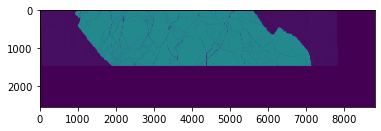

In [49]:
stitched_boosted = stitched*65535
to_save = stitched_boosted.astype(np.uint16)
plt.imshow(stitched)
to_save = Image.fromarray(to_save)
to_save.save('brightness_checker_priority.png')

In [381]:
np.ceil(1)

1.0

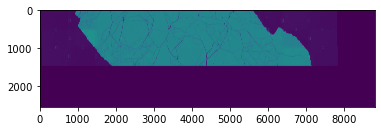

In [46]:
plt.imshow(stitched_boosted)

In [83]:
np.min(stitched_boosted)

0.0

In [36]:
full_set

0          0.292536
1          0.382247
2          0.422059
3          0.437021
4          0.452318
             ...   
7441744    0.262236
7441745    0.364000
7441746    0.427220
7441747    0.434818
7441748    0.407054
Length: 7441749, dtype: float64

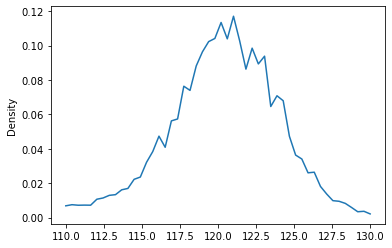

In [214]:
are_you_sure = 1
if are_you_sure == 1:
    full_set = pd.Series((stitched.flatten()[stitched.flatten()>(50/256)])*256)

evaluate_at = np.linspace(110, 130, 50)
ax = full_set.plot.kde(bw_method = 0.0001, ind=evaluate_at)

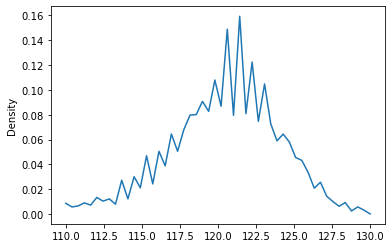

In [223]:
are_you_sure = 1
if are_you_sure == 1:
    full_set = pd.Series((ims_brightened_overall[1,4].flatten()[ims_brightened_overall[1,4].flatten()>(50/256)])*256)
evaluate_at = np.linspace(110, 130, 50)
ax = full_set.plot.kde(bw_method = 0.00015, ind=evaluate_at)

In [50]:
lower_threshold = 115*256
upper_threshold = 128*256
testing_thresholding = stitched_boosted.copy()
testing_thresholding[testing_thresholding>upper_threshold] = upper_threshold
testing_thresholding[testing_thresholding<lower_threshold] = lower_threshold
testing_thresholding = (testing_thresholding -(lower_threshold))*(256*256/(upper_threshold-lower_threshold))
testing_thresholding_image = testing_thresholding.astype(np.uint16)
testing_thresholding_image = Image.fromarray(testing_thresholding_image)
testing_thresholding_image.save('stitched_thresholded_priority.tif')

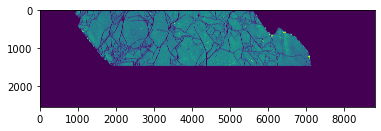

In [51]:
plt.imshow(testing_thresholding)

In [145]:
get_tile_point(17)

(6, 1)

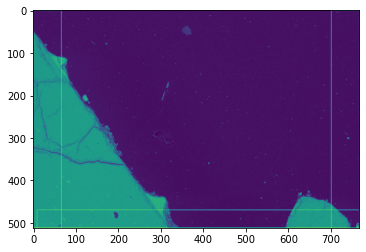

In [146]:
plt.imshow(ims_brightened[8])

In [82]:
np.min(testing_thresholding-lower_threshold)

0.0

In [66]:
testing_thresholding

array([[25600., 25600., 25600., ..., 25600., 25600., 25600.],
       [25600., 25600., 25600., ..., 25600., 25600., 25600.],
       [25600., 25600., 25600., ..., 25600., 25600., 25600.],
       ...,
       [25600., 25600., 25600., ..., 25600., 25600., 25600.],
       [25600., 25600., 25600., ..., 25600., 25600., 25600.],
       [25600., 25600., 25600., ..., 25600., 25600., 25600.]])